---
title: Replication Study - Dissecting racial bias in an algorithm used to manage the health of populations
author: Sophie Seiple
date: '2024-03-05'
image: "hospital.jpg"
description: "Replicating the findings of Obermeyer et. al. (2019) on healthcare risk scores."
format: html
---

## ABSTRACT

In this blogpost I seek to recreate the findings of Obermeyer et. al. (2019), in which they explore a potential algorithm for use scoring high risk patients. This score would then effect the resources and attention dedicated to a patient. Obermeyer et. al. found that the model was biased in that it used costs as an informant of risk scores, and as Black patients costs were typically lower than identical white patients. Obermeyer et. al. posited that this difference could be due to lack of access to healthcare despite appearance of chronic illness, and not that Black patients truly required less healthcare (and therefore healthcare spending) in the next year. We use simulated data based on the data Obermeyer et. al. used to examine whether or not we see a similar pattern in our own recreation of their model and analysis.

### Part A: Data Access

In [106]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

In [107]:
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


### Part B: Recreating Fig. 1

In my recreation of figure 1, I decided to follow Professor Chodrow's example of seperating the data by gender.

In [108]:
import matplotlib as plt
import seaborn as sns

First, I calculated the risk percentile scores for every entry of the dataset.

In [109]:
df['risk_perc'] = (df['risk_score_t'].rank(pct = True)*100).round()

Then, I seperated the entries out into seperate datasets to make them easier to work with, one for each gender and racial combination.

In [110]:
female_b_data = df[(df['dem_female'] == 1) & (df['race'] == 'black')]
female_w_data = df[(df['dem_female'] == 1) & (df['race'] == 'white')]

male_b_data = df[(df['dem_female'] == 0) & (df['race'] == 'black')]
male_w_data = df[(df['dem_female'] == 0) & (df['race'] == 'white')]

Then I performed a series of calculations on each of the individual datasets. For each I calculated the mean number of chronic illnesses by risk percentile, and copied over the original racial and gender distinctions. Afterwards, I re-combined all four into one large dataset for graphing.

In [111]:
mean_chronic_illnesses_female_b = female_b_data.groupby('risk_perc')['gagne_sum_t'].mean()
mean_chronic_illnesses_female_w = female_w_data.groupby('risk_perc')['gagne_sum_t'].mean()

femb = mean_chronic_illnesses_female_b.reset_index()
femb['gender'] = 1
femb['race'] = 'black'

femw = mean_chronic_illnesses_female_w.reset_index()
femw['gender'] = 1
femw['race'] = 'white'


mean_chronic_illnesses_male_b = male_b_data.groupby('risk_perc')['gagne_sum_t'].mean()
mean_chronic_illnesses_male_w = male_w_data.groupby('risk_perc')['gagne_sum_t'].mean()

malb = mean_chronic_illnesses_male_b.reset_index()
malb['gender'] = 0
malb['race'] = 'black'

malw = mean_chronic_illnesses_male_w.reset_index()
malw['gender'] = 0
malw['race'] = 'white'

combined_data = pd.concat([malw, malb, femw, femb])

In [112]:
combined_data

,risk_perc,gagne_sum_t,gender,race
0,0.0,0.030043,0,white
1,1.0,0.113043,0,white
2,2.0,0.112676,0,white
3,3.0,0.276596,0,white
4,4.0,0.117089,0,white
...,...,...,...,...
95,96.0,5.500000,1,black
96,97.0,4.880000,1,black
97,98.0,6.024390,1,black
98,99.0,6.228070,1,black


I used the seaborn facetgrid function to graph two scatterplots side by side seperated by gender and colored according to race.

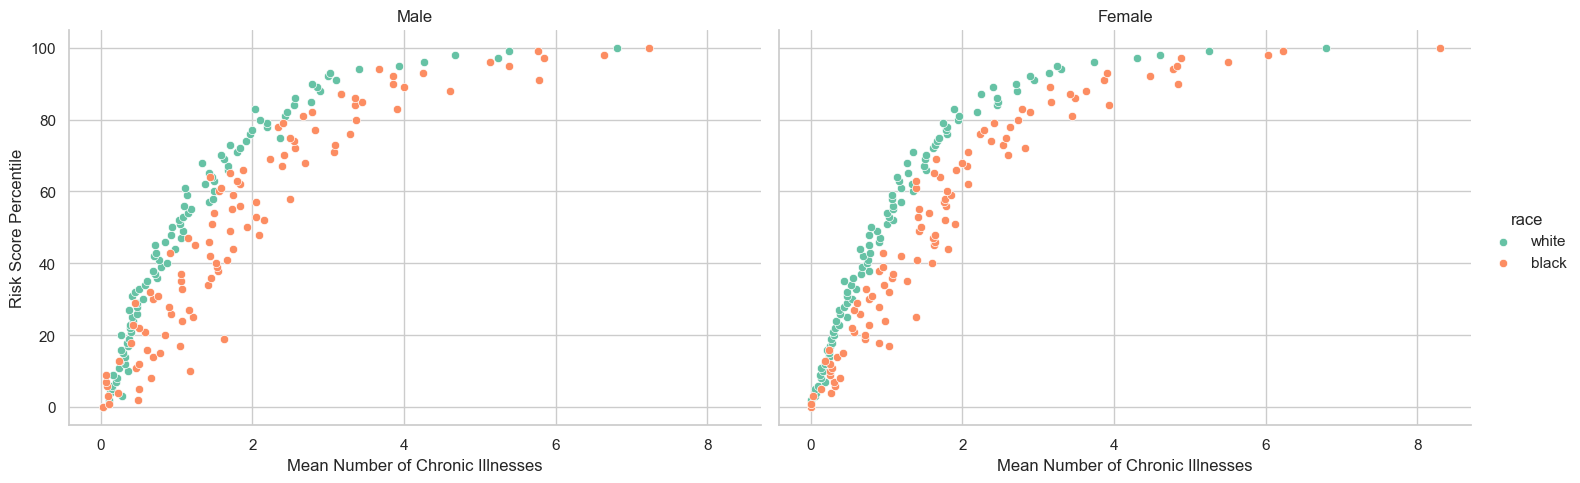

In [113]:
sns.set_theme(style="whitegrid")
sns.set_theme(style="whitegrid")


hue_markers = {'white': 'o', 'black': 'X'}

g = sns.FacetGrid(combined_data, col="gender", hue='race', palette='Set2', height=5, aspect=1.5)
g.map(sns.scatterplot, 'gagne_sum_t', 'risk_perc')
g.add_legend()
g.set_xlabels("Mean Number of Chronic Illnesses")
g.set_ylabels("Risk Score Percentile")
titles = ['Male', 'Female']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


### Part C: Recreating Fig. 3

In [114]:
import matplotlib.pyplot as plt

In order to recreate figure three, I used the risk percentile calculations from the previous figure recreation, and once again separated the data based on race for ease of calculation. For each group I calculated the average cost by number of chronic illness and risk percentile. Then I recombined these datasets for graphing.

In [115]:
bdata = df[df['race']=='black']
wdata = df[df['race']=='white']

meanb_cost = bdata.groupby('risk_perc')['cost_t'].mean().reset_index()
meanb_cost['race'] = 'black'
meanw_cost = wdata.groupby('risk_perc')['cost_t'].mean().reset_index()
meanw_cost['race'] = 'white'

chronicb = bdata.groupby('gagne_sum_t')['cost_t'].mean().reset_index()
chronicw = wdata.groupby('gagne_sum_t')['cost_t'].mean().reset_index()
chronicb['race'] = 'black'
chronicw['race'] = 'white'

combined_data_risk = pd.concat([meanw_cost, meanb_cost])
combined_data_chronic = pd.concat([chronicb, chronicw])

In [116]:
combined_data_chronic

,gagne_sum_t,cost_t,race
0,0,3309.931507,black
1,1,5242.040185,black
2,2,7176.976744,black
3,3,10621.153846,black
4,4,11261.046512,black
5,5,15723.715415,black
6,6,21571.153846,black
7,7,31575.000000,black
8,8,22543.478261,black
9,9,48452.941176,black


I made two, side-by-side graphs to show average cost by risk percentile and number of chronic illnesses just like the authors did.

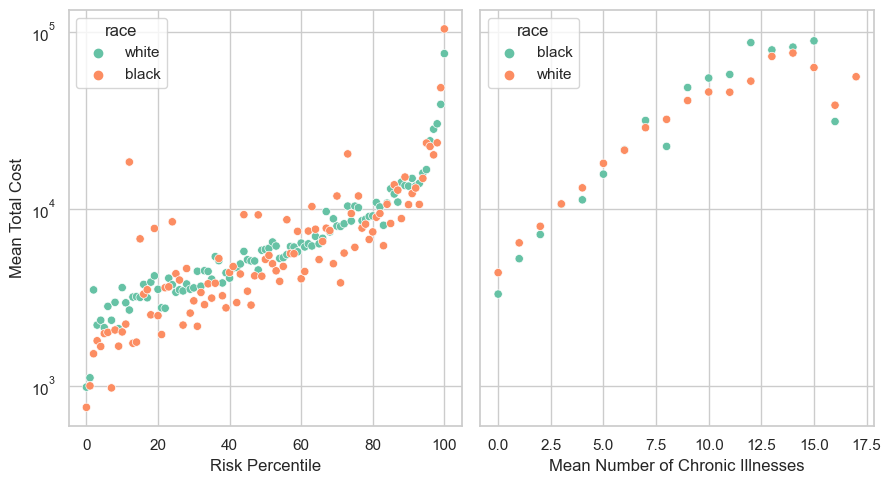

In [117]:
f, axs = plt.subplots(1,2, figsize=(9,5), sharey=True)
sns.scatterplot(data = combined_data_risk,x= 'risk_perc', y='cost_t', hue='race', ax=axs[0], palette='Set2')
axs[0].set_xlabel('Risk Percentile')
axs[0].set_ylabel('Mean Total Cost')
plt.yscale('log')

sns.scatterplot(data=combined_data_chronic,x='gagne_sum_t', y='cost_t', hue='race', ax=axs[1], palette='Set2')
axs[1].set_xlabel('Mean Number of Chronic Illnesses')
axs[1].set_ylabel('')
plt.yscale('log')

f.tight_layout()

This figure shows how mean cost increases with the assigned risk percentile and number of chronic illnesses.

# Part D: Modeling Cost Disparity

First, I determined the percentage of entries that had less than 6 (i.e. 5 or fewer) chronic illnesses.

In [118]:
ltsix = len(df[df['gagne_sum_t'] < 6])
total_rows = len(df)

perc = (ltsix / total_rows) * 100
perc

95.53952115447689

95% of patients in the dataset have five or fewer chronic illnesess. In my opinion, this justifies the choice to focus exclusively on these patients as it is the vast majority of the dataset entries, and we can be confident we have an adequate quantity of data for this demographic in order to draw conclusions.

I then created a new column in a copy of the original dataset with the log cost for each patient.

In [119]:
import numpy as np

dfcopy = df.copy()
dfcopy = dfcopy[dfcopy['cost_t'] != 0]
dfcopy = dfcopy.dropna(subset=['cost_t'])

dfcopy['log_cost'] = np.log(dfcopy['cost_t'])

Next, I created a one-hot-encoding of the race column where Black = 1 and white = 0.

In [120]:
dfcopy.loc[dfcopy['race'] == 'black', 'race_code'] = 1
dfcopy.loc[dfcopy['race'] == 'white', 'race_code'] = 0

I compiled the columns of focus, chronic illness count, log cost, and encoded race, into a new dataset, preddf, to use for training out model.

In [121]:
pred_vars = ['race_code', 'gagne_sum_t', 'log_cost']
preddf = dfcopy[pred_vars]
preddf

,race_code,gagne_sum_t,log_cost
0,0.0,0,7.090077
1,0.0,3,7.863267
2,0.0,0,6.214608
3,0.0,0,7.170120
4,0.0,1,7.003065
...,...,...,...
48779,0.0,0,6.684612
48780,0.0,1,7.696213
48781,0.0,0,6.684612
48782,0.0,3,7.170120


This was a provided function that created new columns based on the degree of polynomial provided. E.g. for degree = 5, it would create four new columns with the chronic illness column taken to powers up to four.

In [122]:
def add_polynomial_features(X, degree):
  X_ = X.copy()
  for j in range(1, degree):
    X_[f"poly_{j}"] = X_["gagne_sum_t"]**j
  return X_

Using this function, I determined the optimal polynomial degree on which to perform linear regression. I did this by looping through multiple options and storing their best, cross-validated scores, and then selecting the max from these options.

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv_scores = {}

for degree in range(1, 15):
    X_poly = add_polynomial_features(preddf, degree)
    cols = list(X_poly.columns)
    cols.remove('log_cost')

    model = LinearRegression()
    model.fit(X_poly[cols], X_poly['log_cost'])

    scores = cross_val_score(model, X_poly[cols], X_poly['log_cost'], cv=5)
    cv_scores[degree] = scores.mean()

In [124]:
print(cv_scores)
max_key = max(cv_scores, key=cv_scores.get)
print("max", max_key)

{1: 0.1453884679359432, 2: 0.14538846793594323, 3: 0.14700305368206448, 4: 0.14692099855465718, 5: 0.14733406563857973, 6: 0.14776094174783683, 7: 0.14807399861141105, 8: 0.1481166054862343, 9: 0.14820529973572671, 10: 0.1483006244495564, 11: 0.14824295620719072, 12: 0.14825610232686962, 13: 0.14828081156156214, 14: 0.14804124249815606}
max 10


I found that the optimal degree was 10, meaning we take $(chronic illnesses)^x$ for x = 1,2,....,9,10.

Next, I fit a linear regression to the data (the degree 10 data) and found the coefficient values. The first in the array is the coefficient associated with race.

In [125]:
X_poly = add_polynomial_features(preddf, 10)
cols = list(X_poly.columns)
cols.remove('log_cost')
print(cols)

model = LinearRegression()
model.fit(X_poly[cols], X_poly['log_cost'])
model.coef_

['race_code', 'gagne_sum_t', 'poly_1', 'poly_2', 'poly_3', 'poly_4', 'poly_5', 'poly_6', 'poly_7', 'poly_8', 'poly_9']


array([-2.67114872e-01,  5.08816332e-01,  5.08816490e-01, -1.03056778e+00,
        5.88024791e-01, -1.77621998e-01,  3.11556829e-02, -3.27057851e-03,
        2.01927003e-04, -6.74580396e-06,  9.39007112e-08])

In [126]:
weight = np.exp(-2.67114872e-01)
weight

0.7655851221198638

This gave me that the estimated percentage of cost incurred by a Black patient compared to an equally sick white patient is 76.56%. This supports the findings of Obermeyer et. al., as Black patients' costs are predicted to be 76.56% that of white patients' costs.

## DISCUSSION

The results of these findings, as well as the paper from Obermeyer et. al. (2019) which this post reproduces, indicate that there is a clear statistical bias in using this model to predict high risk patients. Most obviously, the model violates the fairness measure of error rate parity, as defined by Barocas, Hardt, and Narayanan (2023). Error rate parity is a principle of statistical fairness that aims to ensure fairness in predictive models by requiring that the error rates (i.e. false positive rates and false negative rates) are balanced across different demographic groups. Our model, however, assigns Black patients lower risk scores compared to white patients with the same number of chronic illnesses. This indicates a discrepancy in how errors are distributed between these groups. If the model assigns lower risk scores to Black patients despite having identical medical histories to white patients, it suggests that the model is more likely to make errors, in this context, underestimate risk, for Black patients compared to white patients. This discrepancy in error rates undermines the fairness of the model, as it means that Black patients may not receive appropriate healthcare resources or interventions due to the inaccuracies in the risk assessment. In their paper, Oberymeyer er. al. explore methodologies to account for this potential bias, and find some success is either excluding race as a feature, decorrelating other features from the race variable, or basing predictions more heavily on a combination of health history and patient spending.